# Task 1: Data Preparation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# csv to dataframe 
df = pd.read_csv("A1data.csv")

In [3]:
# get data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ISO3                       90 non-null     object
 1   Countries and areas        90 non-null     object
 2   Region                     90 non-null     object
 3   Sub-region                 90 non-null     object
 4   Income Group               90 non-null     object
 5   Total                      90 non-null     object
 6   Residence (Rural)          85 non-null     object
 7   Residence (Urban)          86 non-null     object
 8   Wealth quintile (Poorest)  83 non-null     object
 9   Wealth quintile (Richest)  83 non-null     object
 10  Time period                90 non-null     object
dtypes: object(11)
memory usage: 7.9+ KB


In [4]:
#find duplicate rows
print(df[df.duplicated()])

   ISO3 Countries and areas Region Sub-region              Income Group Total  \
30  GTM           Guatemala    LAC        LAC  Upper middle income (UM)   10%   
75  TGO                Togo    SSA        WCA            Low income (L)   24%   
76  TGO                Togo    SSA        WCA            Low income (L)   24%   

   Residence (Rural) Residence (Urban) Wealth quintile (Poorest)  \
30                3%               20%                        0%   
75                8%               49%                        0%   
76                8%               49%                        0%   

   Wealth quintile (Richest) Time period  
30                       49%   2014-2015  
75                       78%        2017  
76                       78%        2017  


In [5]:
#drop duplicates
df.drop_duplicates(inplace=True)
print(df[df.duplicated()])

Empty DataFrame
Columns: [ISO3, Countries and areas, Region, Sub-region, Income Group, Total, Residence (Rural), Residence (Urban), Wealth quintile (Poorest), Wealth quintile (Richest), Time period]
Index: []


In [6]:
# convert percentage strings to float
df.iloc[:, 5:10] = df.iloc[:, 5:10].apply(lambda x: x.str.replace('%', '') if x.dtype == "object" else x)
df.iloc[:, 5:10] = df.iloc[:, 5:10].astype(float)    

In [7]:
# finding structural error
df["Income Group"].value_counts()

Income Group
Upper middle income (UM)     32
Lower middle income (LM)     28
Low income (L)               18
High income (H)               7
Lower middle income (LLM)     1
Lower middle income (LMM)     1
Name: count, dtype: int64

In [8]:
# replace with correct category
df["Income Group"] = df["Income Group"].replace({
    "Lower middle income (LLM)": "Lower middle income (LM)",
    "Lower middle income (LMM)": "Lower middle income (LM)"
})
df["Income Group"].value_counts()

Income Group
Upper middle income (UM)    32
Lower middle income (LM)    30
Low income (L)              18
High income (H)              7
Name: count, dtype: int64

In [9]:
# finding structural error
df["Time period"].value_counts()

Time period
2018         16
2018-2019     9
2019          9
2017          8
2013          6
2012          5
2017-2018     5
2015          4
2015-2016     4
2014-2015     3
2010          3
2014          3
2016          3
2011-2012     3
2016-2017     2
2076          1
3562          1
2011          1
2012-2099     1
Name: count, dtype: int64

In [10]:
# remove impossible time periods
df = df[(df["Time period"] != '3562') & (df["Time period"] != '2012-2099')]

In [11]:
# remove impossible percentages
df = df.drop(df[(df["Total"] < 0) | (df["Total"] > 100)].index)
df = df.drop(df[(df["Residence (Rural)"] < 0) | (df["Residence (Rural)"] > 100)].index)
df = df.drop(df[(df["Wealth quintile (Poorest)"] < 0) | (df["Wealth quintile (Poorest)"] > 100)].index)
df = df.drop(df[(df["Wealth quintile (Richest)"] < 0) | (df["Wealth quintile (Richest)"] > 100)].index)

df = df[df["Countries and areas"] != "Kenya"]

In [12]:
# columns with NaN values
df.isnull().sum()

ISO3                         0
Countries and areas          0
Region                       0
Sub-region                   0
Income Group                 0
Total                        0
Residence (Rural)            5
Residence (Urban)            4
Wealth quintile (Poorest)    7
Wealth quintile (Richest)    7
Time period                  0
dtype: int64

In [13]:
# get skewness values
print(df[["Residence (Rural)", "Residence (Urban)", "Wealth quintile (Poorest)", "Wealth quintile (Richest)"]].skew())

Residence (Rural)            1.004273
Residence (Urban)            0.280391
Wealth quintile (Poorest)    1.599889
Wealth quintile (Richest)   -0.490663
dtype: object


In [14]:
# get the mean values of each income group for columns with NaN values, round to one decimal 
income_group_means = df.groupby("Income Group")[["Residence (Rural)", "Residence (Urban)", "Wealth quintile (Richest)"]].transform(lambda x: round(x.median(), 1))

# median for Wealth quintile (Poorest) since skew is >1.5, round to one decimal 
income_group_medians = df.groupby("Income Group")[["Wealth quintile (Poorest)"]].transform(lambda x: round(x.median(), 1))

In [15]:
# replace Nan values with means/medians of that income group for the column
df["Residence (Rural)"] = df["Residence (Rural)"].fillna(income_group_means["Residence (Rural)"])
df["Residence (Urban)"] = df["Residence (Urban)"].fillna(income_group_means["Residence (Urban)"])
df["Wealth quintile (Richest)"] = df["Wealth quintile (Richest)"].fillna(income_group_means["Wealth quintile (Richest)"])
df["Wealth quintile (Poorest)"] = df["Wealth quintile (Poorest)"].fillna(income_group_medians["Wealth quintile (Poorest)"])

In [16]:
# confirm no Nan values
df.isnull().sum()

ISO3                         0
Countries and areas          0
Region                       0
Sub-region                   0
Income Group                 0
Total                        0
Residence (Rural)            0
Residence (Urban)            0
Wealth quintile (Poorest)    0
Wealth quintile (Richest)    0
Time period                  0
dtype: int64

In [17]:
# write to csv
df.to_csv("S3902159-cleaned-A1data.csv", index=False)

# Task 2: Data Exploration

In [18]:
# cleaned csv to dataframe 
cleaned_df = pd.read_csv("S3902159-cleaned-A1data.csv")

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ISO3                       83 non-null     object 
 1   Countries and areas        83 non-null     object 
 2   Region                     83 non-null     object 
 3   Sub-region                 83 non-null     object 
 4   Income Group               83 non-null     object 
 5   Total                      83 non-null     float64
 6   Residence (Rural)          83 non-null     float64
 7   Residence (Urban)          83 non-null     float64
 8   Wealth quintile (Poorest)  83 non-null     float64
 9   Wealth quintile (Richest)  83 non-null     float64
 10  Time period                83 non-null     object 
dtypes: float64(5), object(6)
memory usage: 7.3+ KB


## Task 2.1 

In [20]:
# group Total by Region with median
median_total_by_region = cleaned_df.groupby("Region")["Total"].median()
print(median_total_by_region)

Region
EAP     47.5
ECA     77.5
LAC     43.0
MENA    33.0
SA      39.0
SSA      6.5
Name: Total, dtype: float64


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Median Total Percentage of Children with Internet at Home')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Total Percentage')

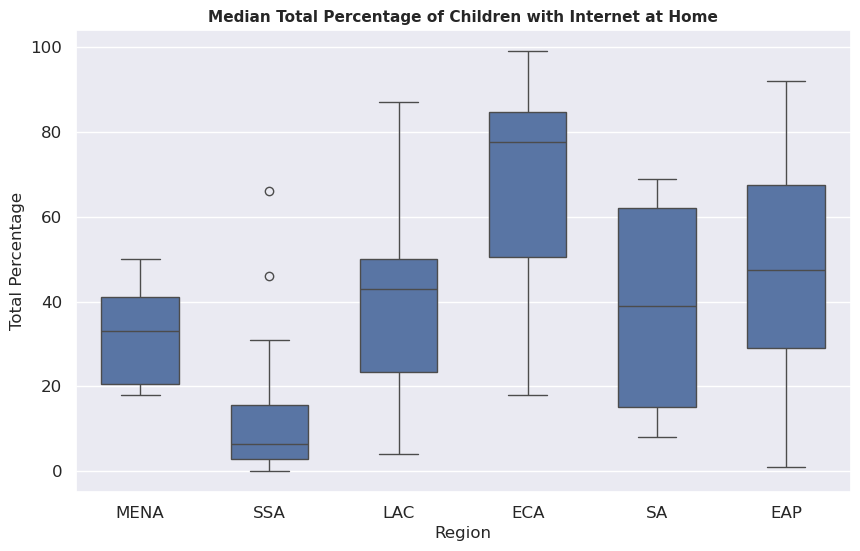

In [21]:
# make boxplot
sns.set_theme(style="darkgrid")
 
plt.figure(figsize=(10, 6)) 
median_total_boxplot = sns.boxplot(x="Region", y="Total", data=cleaned_df, width=0.6)

# title and text sizes
median_total_boxplot.set_title("Median Total Percentage of Children with Internet at Home", fontsize=11, fontweight='bold')
median_total_boxplot.set_xlabel("Region", fontsize=12)
median_total_boxplot.set_ylabel("Total Percentage", fontsize=12)
median_total_boxplot.tick_params(axis='x', labelsize=12)  
median_total_boxplot.tick_params(axis='y', labelsize=12)  

## Task 2.2 

In [22]:
# mean for Wealth quintile (Poorest) and Wealth quintile (Richest)
mean_poorest = cleaned_df["Wealth quintile (Poorest)"].mean().round(2)
mean_richest = cleaned_df["Wealth quintile (Richest)"].mean().round(2)

print(f"Wealth quintile (Poorest) Mean: {mean_poorest}")
print(f"Wealth quintile (Poorest) Mean: {mean_richest}")

Wealth quintile (Poorest) Mean: 16.89
Wealth quintile (Poorest) Mean: 62.05


In [23]:
# sort top 10 Wealth quintile (Poorest) and Wealth quintile (Richest) by Countries
top_poorest = df.sort_values(by="Wealth quintile (Poorest)", ascending=False).head(10)
top_richest = df.sort_values(by="Wealth quintile (Richest)", ascending=False).head(10)

# show relevant columns for each df
top_poorest[["Countries and areas", "Wealth quintile (Poorest)"]]
top_richest[["Countries and areas","Wealth quintile (Richest)"]]

,Countries and areas,Wealth quintile (Poorest)
65,Somalia,100.0
9,Brazil,84.0
77,Tonga,83.0
15,Chile,75.0
68,Sri Lanka,71.0
73,North Macedonia,68.0
63,Serbia,65.0
36,Japan,64.0
40,Kyrgyzstan,56.0
49,Montenegro,55.0


,Countries and areas,Wealth quintile (Richest)
10,Bulgaria,100.0
63,Serbia,100.0
65,Somalia,100.0
5,Barbados,100.0
73,North Macedonia,100.0
18,Costa Rica,99.0
15,Chile,99.0
17,Colombia,99.0
27,Georgia,99.0
68,Sri Lanka,99.0


## Task 2.3 

In [24]:
# get Lower Middle Income group only
lm_df = cleaned_df.loc[cleaned_df["Income Group"] == "Lower middle income (LM)"]

In [25]:
# categorise countries into residence types
melted_lm = pd.melt(lm_df, id_vars=["Countries and areas" , "Region"], 
                      value_vars=["Residence (Rural)", "Residence (Urban)"],
                      var_name="Residence Type", value_name="Percentage")
melted_lm

,Countries and areas,Region,Residence Type,Percentage
0,Angola,SSA,Residence (Rural),2.0
1,Bangladesh,SA,Residence (Rural),31.0
2,Bolivia (Plurinational State of),LAC,Residence (Rural),3.0
3,Cameroon,SSA,Residence (Rural),0.0
4,Cote d'Ivoire,SSA,Residence (Rural),1.0
5,Djibouti,SSA,Residence (Rural),2.0
6,Egypt,MENA,Residence (Rural),9.0
7,Ghana,SSA,Residence (Rural),10.0
8,India,SA,Residence (Rural),5.0
9,Indonesia,EAP,Residence (Rural),11.0


Residence (Rural) IQL: 15.0
Residence (Urban) IQL: 39.0


<Figure size 500x600 with 0 Axes>

Text(0.5, 1.0, 'Total Percentage of Rural and Urban Residences with Internet Access')

Text(0.5, 0, 'Residence Type')

Text(0, 0.5, 'Total Percentage')

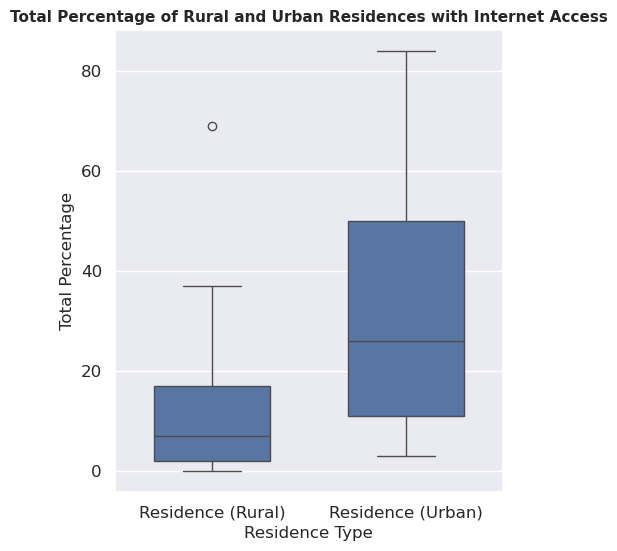

In [26]:
# calculate q1 and q3 
q1_rural = lm_df['Residence (Rural)'].quantile(0.25)
q3_rural = lm_df['Residence (Rural)'].quantile(0.75)
q1_urban = lm_df['Residence (Urban)'].quantile(0.25)
q3_urban = lm_df['Residence (Urban)'].quantile(0.75)

# calculate IQR
iqr_rural = q3_rural - q1_rural
iqr_urban = q3_urban - q1_urban

print(f"Residence (Rural) IQL: {iqr_rural}")
print(f"Residence (Urban) IQL: {iqr_urban}")

# make boxplot
sns.set_theme(style="darkgrid")
 
plt.figure(figsize=(5, 6)) 
median_total_boxplot = sns.boxplot(x="Residence Type", y="Percentage", data=melted_lm, width=0.6)

# title and text sizes
median_total_boxplot.set_title("Total Percentage of Rural and Urban Residences with Internet Access", fontsize=11, fontweight='bold')
median_total_boxplot.set_xlabel("Residence Type", fontsize=12)
median_total_boxplot.set_ylabel("Total Percentage", fontsize=12)
median_total_boxplot.tick_params(axis='x', labelsize=12)  
median_total_boxplot.tick_params(axis='y', labelsize=12)  

,Residence (Rural),Residence (Urban)
Region,,
EAP,14.60,41.20
ECA,30.00,60.33
LAC,2.50,11.50
MENA,14.33,36.00
SA,13.33,28.00
SSA,7.62,21.85


Text(0.5, 1.0, 'Means of Rural and Urban Residents with Internet Access by Region')

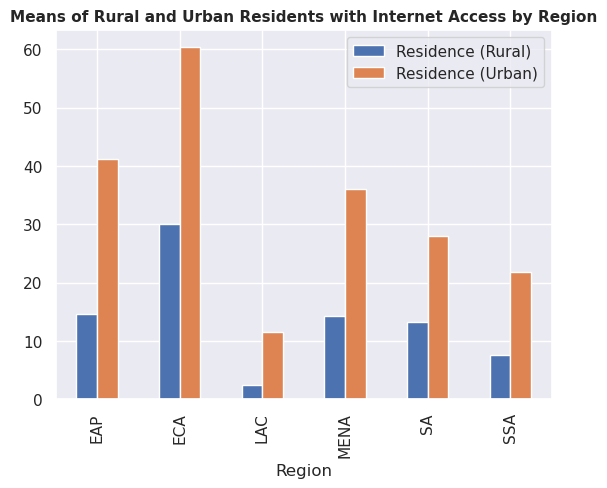

In [27]:
# mean Residence (Rural/Urban) percentage for each region
group_by_region_lm = lm_df.groupby("Region")[["Residence (Rural)", "Residence (Urban)"]].mean().round(2)
group_by_region_lm

# create bar plot
region_residence_boxplot = group_by_region_lm.plot.bar()
region_residence_boxplot.set_title("Means of Rural and Urban Residents with Internet Access by Region", fontsize=11, fontweight='bold')

Residence (Rural) kurtosis: 6.33
Residence (Urban) kurtosis: -0.54


<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: xlabel='Residence (Rural)', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Residence (Rural) with KDE')

Text(0.5, 0, 'Percentage of Internet Access')

Text(0, 0.5, 'Frequency')

<Axes: >

<Axes: xlabel='Residence (Urban)', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Residence (Urban) with KDE')

Text(0.5, 0, 'Percentage of Internet Access')

Text(0, 0.5, 'Frequency')

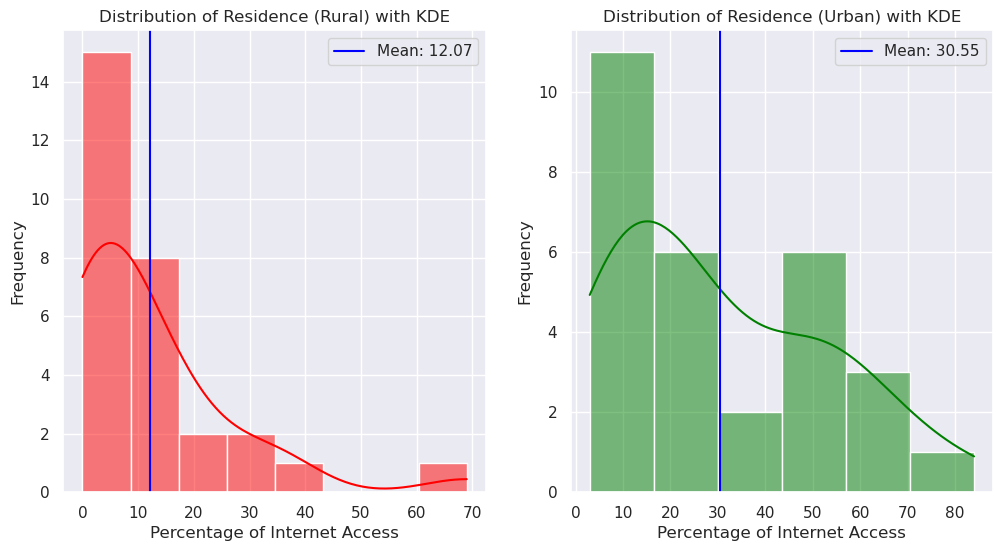

In [28]:
# calulate kurtosis
kurtosis_rural = lm_df['Residence (Rural)'].kurt().round(2)
kurtosis_urban = lm_df['Residence (Urban)'].kurt().round(2)

print(f"Residence (Rural) kurtosis: {kurtosis_rural}")
print(f"Residence (Urban) kurtosis: {kurtosis_urban}")

# calculatge mean for two categories
mean_rural = lm_df["Residence (Rural)"].mean().round(2)
mean_urban = lm_df["Residence (Urban)"].mean().round(2)

# make historgram with KDE for Residence (Rural/Urban)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(lm_df["Residence (Rural)"], kde=True, color="red")
plt.title("Distribution of Residence (Rural) with KDE")
plt.xlabel("Percentage of Internet Access")
plt.ylabel("Frequency")
# draw line where mean is 
plt.axvline(x = mean_rural, color = "blue", label = f"Mean: {mean_rural}")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(lm_df["Residence (Urban)"], kde=True, color="green")
plt.title("Distribution of Residence (Urban) with KDE")
plt.xlabel("Percentage of Internet Access")
plt.ylabel("Frequency")
# draw line where mean is 
plt.axvline(x = mean_urban, color = "blue", label = f"Mean: {mean_urban}")
plt.legend()